In [83]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

### Reading data

In [7]:
X1 = pd.read_csv("preprocessed_datasets/bank_data.csv")
y1 = pd.read_csv("preprocessed_datasets/bank_target.csv")
X2 = pd.read_csv("preprocessed_datasets/gym_data.csv")
y2 = pd.read_csv("preprocessed_datasets/gym_target.csv")
X3 = pd.read_csv("preprocessed_datasets/heartDisease_data.csv")
y3 = pd.read_csv("preprocessed_datasets/heartDisease_target.csv")
X4 = pd.read_csv("preprocessed_datasets/titanic_data.csv")
y4 = pd.read_csv("preprocessed_datasets/titanic_target.csv")

In [12]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y1)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42, stratify=y3)
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42, stratify=y4)

### Establishing baseline brier score for default hyperparameters

In [ ]:
RANDOM_STATE = 42
model = lgb.LGBMClassifier(random_state=RANDOM_STATE)
model.fit(X1_train, y1_train)
y_proba = model.predict_proba(X1_test)[:, 1]
brier1 = brier_score_loss(y1_test, y_proba)
model.fit(X2_train, y2_train)
y2_proba = model.predict_proba(X2_test)[:, 1]
brier2 = brier_score_loss(y2_test, y2_proba)
model.fit(X3_train, y3_train)
y3_proba = model.predict_proba(X3_test)[:, 1]
brier3 = brier_score_loss(y3_test, y3_proba)
model.fit(X4_train, y4_train)
y4_proba = model.predict_proba(X4_test)[:, 1]
brier4 = brier_score_loss(y4_test, y4_proba)

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklea

[LightGBM] [Info] Number of positive: 4231, number of negative: 4698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 8929, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473849 -> initscore=-0.104699
[LightGBM] [Info] Start training from score -0.104699
[LightGBM] [Info] Number of positive: 635, number of negative: 948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 1583, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.401137 -> initscore=-0.400730
[LightGBM] 

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [27]:
print(brier1)
print(brier2)
print(brier3)
print(brier4)

0.1835232471728478
0.2018081787955161
0.0982194936261805
0.178996854771902


### Random search optimization
https://docs.aws.amazon.com/sagemaker/latest/dg/lightgbm-hyperparameters.html
https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html?utm_source=chatgpt.com

In [72]:
param_grid = {
    'num_leaves': [7 ,15, 31, 63], ### should be less than 2^max_depth
    "max_depth": [-1, 3, 5, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500, 1000],
}

In [73]:
N_ITER = 100
RANDOM_STATE = 42
SCORER = 'neg_brier_score'  # maximize negative value because in standard brier score the lower, the better
WINDOW_SIZE = 10           
TOL = 0.001 
CV = 5

In [ ]:
iters = np.arange(1, N_ITER + 1)

In [74]:
model = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs = 1)

In [75]:
rnd = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=N_ITER,
    scoring=SCORER,
    verbose=0,
    cv=CV,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    refit=True
)

#### Bank data

In [127]:
rnd.fit(X1_train, y1_train)

[LightGBM] [Info] Number of positive: 4231, number of negative: 4698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 8929, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.473849 -> initscore=-0.104699
[LightGBM] [Info] Start training from score -0.104699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 3, ...], 'n_estimators': [100, 300, ...], 'num_leaves': [7, 15, ...]}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [128]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [129]:
rnd.best_params_

{'num_leaves': 7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1}

In [130]:
best_so_far[-1]

np.float64(0.18327052638761976)

### Criterium of stabilization - in 10 steps in a row there is no improvement in brier score more than 1e-3

In [131]:
WINDOW_SIZE = 10 
ABS_TOL = 0.001   

In [132]:
def detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL, window_len = WINDOW_SIZE):
    """
    Szuka pierwszego okna długości 10 takie, że wszystkie 9 kolejnych różnic
    między elementami okna mają wartość absolutną < abs_tol.
    Zwraca (stabilized_at_1based, stabilized_value) lub (None, None).
    """
    arr = np.asarray(best_so_far)
    n = arr.shape[0]
    if n < window_len:
        return None, None

    for start in range(0, n - window_len + 1):
        window = arr[start:start + window_len]
        diffs = np.abs(np.diff(window)) 
        if np.all(diffs < abs_tol):
            return start + 1, float(window[0])
    return None, None

In [133]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [134]:
print(stabilized_at, stabilized_value)

2 0.18522035074867702


In [146]:
def chart_random(stabilized_at, brier_per_iter, iters, best_so_far, default):
    plt.figure(figsize=(10, 5))
    plt.scatter(iters, brier_per_iter, s=12, alpha=0.6, label='Brier per iteration')
    plt.plot(iters, best_so_far, linewidth=2, label='Best so far')
    if stabilized_at is not None:
        plt.axvline(stabilized_at, linestyle='--', linewidth=1, label=f'Stabilized at {stabilized_at}')
    plt.plot(iters, [default]*len(iters), linewidth = 1, color='red', label = "Default hyperparams")
    plt.xlabel('Iteration')
    plt.ylabel('Brier score (lower is better)')
    plt.title('Brier per Random Search iteration and best-so-far')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

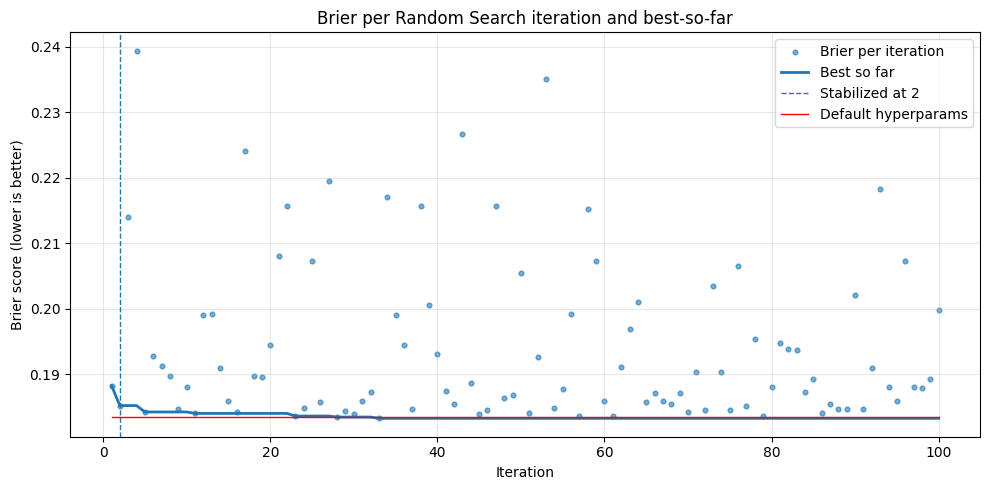

In [ ]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier1)

#### Gym data

In [139]:
rnd.fit(X2_train, y2_train)

[LightGBM] [Info] Number of positive: 635, number of negative: 948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 1583, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.401137 -> initscore=-0.400730
[LightGBM] [Info] Start training from score -0.400730
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 3, ...], 'n_estimators': [100, 300, ...], 'num_leaves': [7, 15, ...]}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [140]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [141]:
rnd.best_params_

{'num_leaves': 7, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}

In [142]:
best_so_far[-1]

np.float64(0.15148435855666098)

In [143]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [144]:
print(stabilized_at, stabilized_value)

9 0.1528246017068949


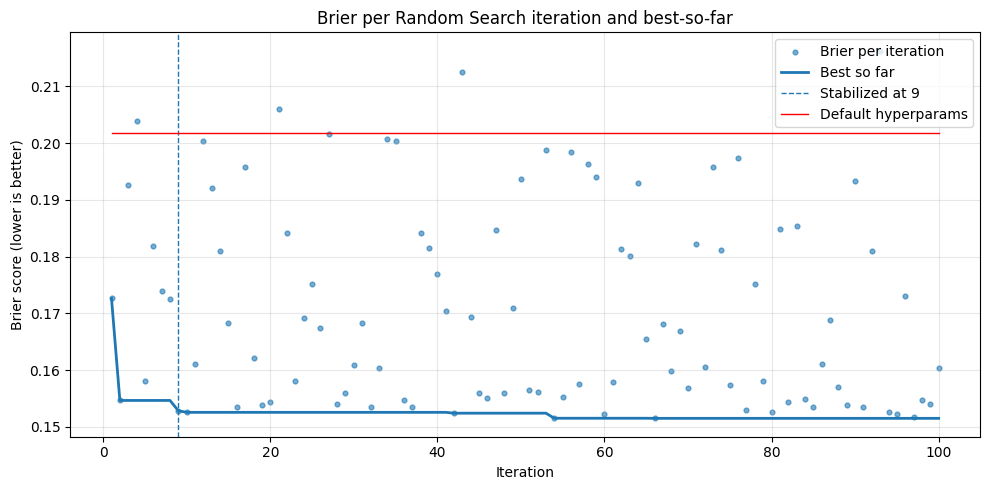

In [147]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier2)

#### Heart disease data

In [148]:
rnd.fit(X3_train, y3_train)

[LightGBM] [Info] Number of positive: 406, number of negative: 328
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 369
[LightGBM] [Info] Number of data points in the train set: 734, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553134 -> initscore=0.213340
[LightGBM] [Info] Start training from score 0.213340


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 3, ...], 'n_estimators': [100, 300, ...], 'num_leaves': [7, 15, ...]}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [149]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [150]:
rnd.best_params_

{'num_leaves': 7, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}

In [151]:
best_so_far[-1]

np.float64(0.12361214714310523)

In [ ]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [ ]:
print(stabilized_at, stabilized_value)

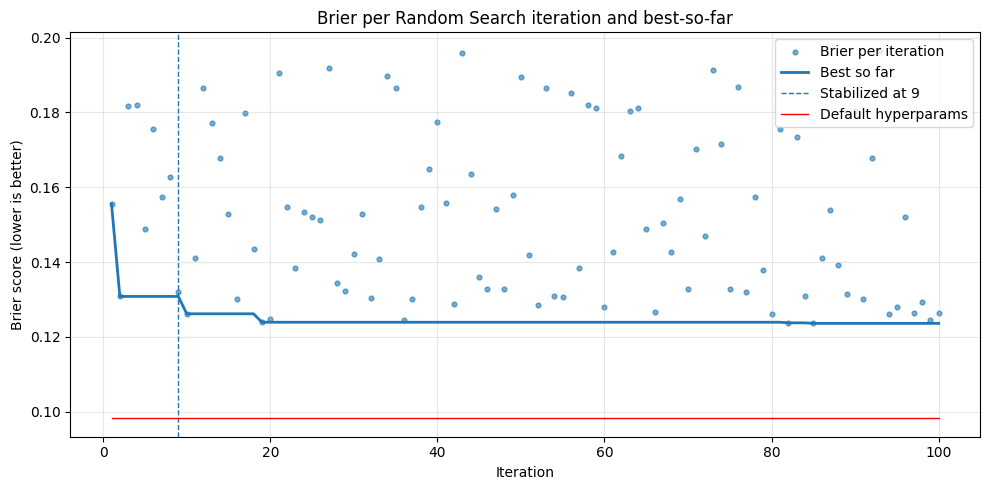

In [152]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier3)

#### Titanic data

In [153]:
rnd.fit(X4_train, y4_train)

[LightGBM] [Info] Number of positive: 271, number of negative: 437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 464
[LightGBM] [Info] Number of data points in the train set: 708, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382768 -> initscore=-0.477814
[LightGBM] [Info] Start training from score -0.477814


c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Admin\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [-1, 3, ...], 'n_estimators': [100, 300, ...], 'num_leaves': [7, 15, ...]}"
,n_iter,100
,scoring,'neg_brier_score'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [154]:
cv_results = pd.DataFrame(rnd.cv_results_)
mean_test_scores = cv_results['mean_test_score'].values  
brier_per_iter = -mean_test_scores
best_so_far = np.minimum.accumulate(brier_per_iter)

In [155]:
rnd.best_params_

{'num_leaves': 7, 'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.01}

In [156]:
best_so_far[-1]

np.float64(0.10549575273309986)

In [157]:
stabilized_at, stabilized_value = detect_stabilization_by_last(best_so_far, abs_tol=ABS_TOL)

In [158]:
print(stabilized_at, stabilized_value)

9 0.10765560294731595


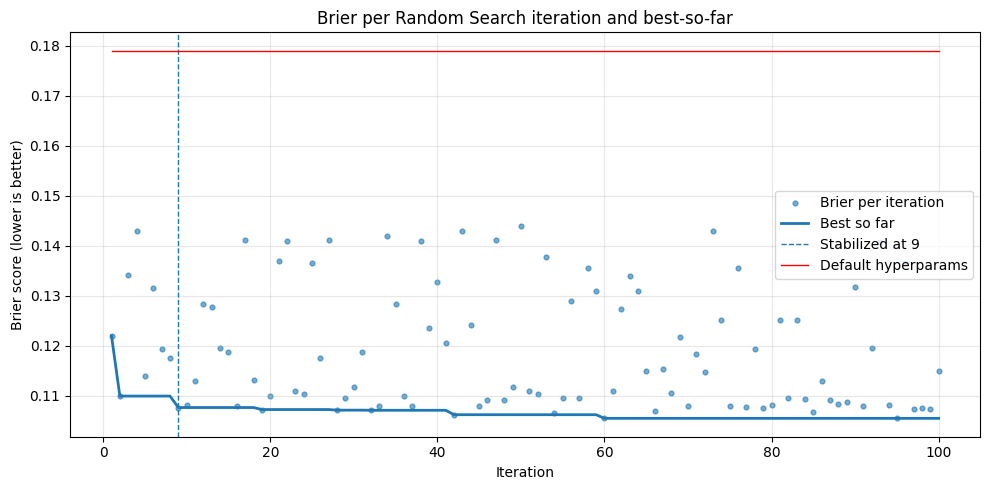

In [159]:
chart_random(stabilized_at=stabilized_at, brier_per_iter=brier_per_iter, iters=iters, best_so_far=best_so_far, default=brier4)